# Modelo VAE

im a coping this notebook https://github.com/evasnow1992/DeepGenerativeModelLINCS/blob/master/deep_generative_model_LINCS.ipynb

A **Variational Autoencoder (VAE)** is a generative model that learns to encode input data into a low-dimensional **latent space** and then decode it back to reconstruct the original input. Unlike traditional autoencoders, VAEs learn a **probabilistic latent space** by mapping inputs to a distribution (mean and variance), allowing them to generate new, realistic samples by sampling from that space.


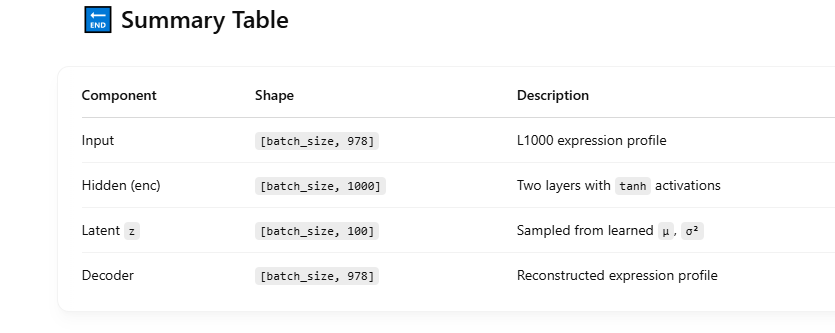

In this context, the VAE is used to **compress high-dimensional gene expression profiles (978 landmark genes)** into a **low-dimensional latent space (100 features)** that captures the essential biological variation. This latent space can then be used for tasks like:

- 🧬 **Drug effect representation**  
- 🔍 **Clustering or comparing perturbagens**
- 📉 **Dimensionality reduction** before classification
- 🤖 **Input to downstream ML models**

**What is the decoder used for?**

The encoder is the main tool used to extract compact representations (100-dim vectors) of the gene expression profiles.

The decoder is used only during training to ensure the latent representation preserves enough information to reconstruct the original 978-gene input.

The goal is not to use the decoder later, but to train a powerful encoder.


So, the VAE learns a compact, meaningful representation of gene expression changes caused by different compounds or genetic perturbations.

In [2]:
!pip install cmapPy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 9.1 MB/s eta 0:00:00


In [3]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
import pandas as pd
import gzip, shutil
import os
import pkg_resources

from cmapPy.pandasGEXpress.parse import parse
import torch

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch
from torch import nn
from torch.autograd import Variable

In [8]:
# Load model components
encoder = torch.load('/content/drive/MyDrive/CMAPS_VAE/VAE_encode_SMGP.pth', weights_only=False)
mu_layer = torch.load('/content/drive/MyDrive/CMAPS_VAE/VAE_mu_SMGP.pth', weights_only=False)
logvar_layer = torch.load('/content/drive/MyDrive/CMAPS_VAE/VAE_logvar_SMGP.pth', weights_only=False)
input_data = pd.read_csv('/content/drive/MyDrive/CMAPS_VAE/drug_signatures_drugcomb_cmaps_combination.csv')




/usr/local/lib/python3.11/dist-packages/torch/serialization.py:1580: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.11/dist-packages/torch/serialization.py:1580: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.11/dist-packages/torch/serialization.py:1580: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attribute

In [11]:
encoder.eval()
mu_layer.eval()
logvar_layer.eval()

if torch.cuda.is_available():
    encoder = encoder.cuda()
    mu_layer = mu_layer.cuda()
    logvar_layer = logvar_layer.cuda()

**Step 2:** Prepare Your Input Data
Make sure your input is:

A tensor of shape [batch_size, 978]

Of type torch.FloatTensor

Normalized the same way as during training (if applicable)

In [10]:
import torch
import numpy as np
import pandas as pd

# 1. Transpose and convert to tensor
X = input_data.T.values.astype(np.float32)  # shape: (126, 978)
X_tensor = torch.tensor(X)

if torch.cuda.is_available():
    X_tensor = X_tensor.cuda()

 **Step 3:** Encode and Get μ, σ² and z

In [12]:
with torch.no_grad():
    h1 = encoder[1](encoder[0](X_tensor))
    h = encoder[3](encoder[2](h1))

    mu = mu_layer(h)
    logvar = logvar_layer(h)

    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)  # Random noise
    z = mu + std * eps  # Reparameterization trick


In [14]:
z.shape

torch.Size([127, 100])

In [15]:
mu.shape

torch.Size([127, 100])

### Que usar como embedding en el modelo??

Chat dice que mu, pues eso haré

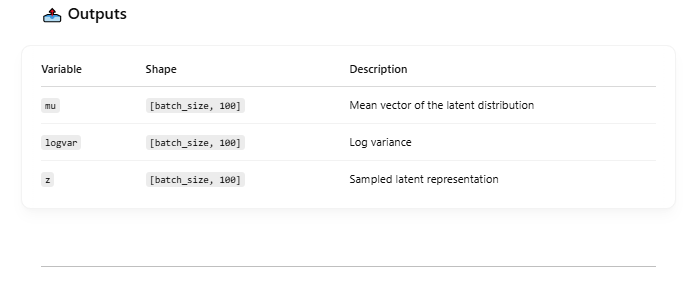

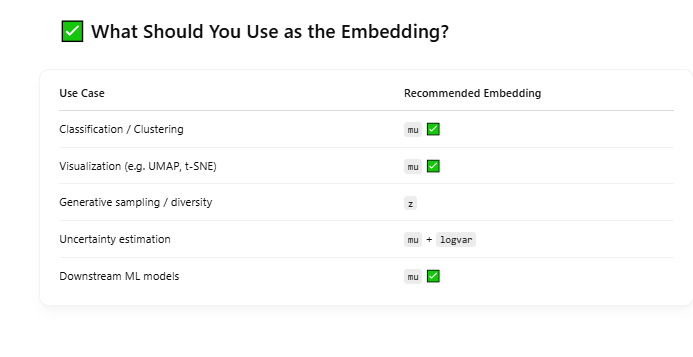

**Next steps**

100 variables es demasiado para el modelo

1. Alomejor hacer el training del modelo pero en vez de con 100 con 10 the final layer. Esto no lo hacen en el paper tendría yo que tirar de volver a entrenr el modelo como ellos pero hacerlo de 10 hidden layers
2. Alomejor hacer una PCA Y reducirlo a 10 componentes --> chat
